# Introduction

I'm going to review different stocks and do the timseries analysis on them. The goal is to find the stocks that are non-stationary and check what is the result of the hurst exponent and get the stock with higher value in the hurst exponent because it will be useful for our momentum trading strategy.

I'm going to work with daily data from yahoo finance.

**Steps to follow:**

1 - Import the libraries

2 - Get the data from yahoo finance

3 - Analyze timeseries using adfuller test and hurst exponent

4 - Get the stocks with a hurst exponent greater than a defined threshold and plot them

5 - Calculate the volatility of the selected stocks and in my case, I'm going to select the stock with the highest volatility

6 - According to the hurst exponent and the visual analysis, select the stocks that are non-stationary and get the best one for our momentum trading strategy.

## Syllabus

* [1 - Import the libraries](#1)
* [2 - Get data](#2)
* [3 - Selection timeseries for momentum trading strategy](#3)
* [4 - Analyze selected stocks](#4)

## 1 - Import the libraries <a id="1"></a>

In [89]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import datetime
import os
from hurst import compute_Hc
from typing import List

In [90]:
def get_stocks(tickers: List[str], start_date: str = '2000-01-01', 
               end_date: str = datetime.datetime.today().strftime('%Y-%m-%d')) -> pd.DataFrame:
    """
    Download historical stock data for the specified tickers.

    Parameters:
    ----------
    tickers : List[str]
        A list of ticker symbols to download data for.
    start_date : str, optional (default='2000-01-01')
        The start date for the data download in YYYY-MM-DD format.
    end_date : str, optional (default=today's date in YYYY-MM-DD format)
        The end date for the data download in YYYY-MM-DD format.

    Returns:
    -------
    pd.DataFrame
        A Pandas DataFrame containing the Open, High, Low, Close, and Volume data
        for the specified tickers and date range.
    """
    ohlc = yf.download(tickers, start=start_date, end=end_date, interval='1d')
    return ohlc

In [84]:
def remove_sparse_columns(df: pd.DataFrame, min_rows: int = 5000) -> pd.DataFrame:
    """
    Remove sparse columns from a Pandas DataFrame.

    Parameters:
    ----------
    df : pd.DataFrame
        A Pandas DataFrame to remove sparse columns from.
    min_rows : int, optional (default=5000)
        The minimum number of non-null values a column must have to be kept.

    Returns:
    -------
    pd.DataFrame
        A new Pandas DataFrame with sparse columns removed.
    """
    df_copy = df.copy()

    # Get columns with at least `min_rows` non-null values. More data is better.
    columns_with_non_null_values = df_copy.count()[df_copy.count() >= min_rows].index

    # Remove columns with null values
    df_copy = df_copy[columns_with_non_null_values]
    df_copy = df_copy.dropna(axis=1)

    return df_copy

In [85]:
def normalize_df(df: pd.DataFrame, column: str = 'Adj Close', column_index: str = 'Date') -> pd.DataFrame:
    """
    Normalize a Pandas DataFrame by renaming columns and the index.

    Parameters:
    ----------
    df : pd.DataFrame
        A Pandas DataFrame to be normalized.
    column : str, optional (default='Adj Close')
        The column name to use for the normalized DataFrame.
    column_index : str, optional (default='Date')
        The name to use for the index of the normalized DataFrame.

    Returns:
    -------
    pd.DataFrame
        A new Pandas DataFrame with normalized column names and index.
    """
    df_copy = df.copy()

    # If the DataFrame has multi-level columns, select the specified column
    if df.columns.nlevels > 1:
        df_copy = df_copy[column]
        df_copy.index = df_copy.index.get_level_values(column_index)

    # Rename columns and index to remove special characters and convert to lowercase
    df_copy.columns = df_copy.columns.str.replace('[^0-9a-zA-Z]+', '_', regex=True).str.lower()
    df_copy.index.name = df_copy.index.name.lower()

    return df_copy

## 2 - Get data <a id="2"></a>

We have a file that contains the list of stocks that we want to analyze. We are going to read the file and get the list of stocks. Then, we are going to get the data from yahoo finance if we don't have it in our local machine. If we have a file called stocks.csv, we are going to read it and get the data from there.

In [2]:
tickers = pd.read_csv('assets/stock_info.csv')[['Ticker']].rename(columns={'Ticker': 'ticker'}).values.flatten().tolist()

In [3]:
tickers[:5]

['A', 'AA', 'AAN', 'AAT', 'AAV']

In [5]:
loaded_from_file = False
if os.path.exists('assets/stocks.csv'):
    stocks = pd.read_csv('assets/stocks.csv', index_col=0)
    loaded_from_file = True
else:
    stocks = get_stocks(tickers)
    stocks.to_csv('assets/stocks.csv')

In [86]:
if not loaded_from_file:
    stocks = normalize_df(stocks)

In [8]:
stocks = remove_sparse_columns(stocks, min_rows=5000)

In [9]:
stocks.head(3)

,aa,aapl,abc,acgl,adbe,adc,adsk,adx,aee,aehr,...,wtba,wvfc,x,xel,xom,xray,ypf,yum,zion,znh
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00-05:00,72.063606,0.859423,2.988897,1.277778,16.274673,3.164682,8.052903,4.843406,11.112337,4.8125,...,6.071854,5.867258,24.304806,7.294349,19.466265,6.885552,11.532703,4.770266,37.660606,5.888203
2000-01-04 00:00:00-05:00,72.397484,0.786965,2.784837,1.270833,14.909401,3.079533,7.660817,4.780035,11.112337,4.8125,...,6.071854,5.867258,23.397551,7.462310,19.093410,6.885552,11.453301,4.674382,35.836948,5.957072
2000-01-05 00:00:00-05:00,76.571045,0.798481,3.000901,1.388889,15.204173,3.022768,7.178246,4.743824,11.542211,4.7500,...,6.445953,5.805497,23.636314,7.750246,20.134300,7.004584,11.512856,4.698353,35.794537,5.784901


In [10]:
def get_non_stationary_stocks(df):
    selected_stocks = df.copy()
    count = 0
    for ticker in df.columns:
        pvalue = adfuller(df[ticker])[1]
        if pvalue < 0.05:
            # Remove the ticker from the list
            selected_stocks = selected_stocks.drop(ticker, axis=1)
            count += 1

    print(f'{count} stationary stock timeseries removed')

    return selected_stocks

In [31]:
def get_trending_stocks(df, threshold=0.5):
    selected_stocks = df.copy()
    count = 0
    for ticker in df.columns:
        try:
            H, _, _ = compute_Hc(df[ticker], kind='random_walk', simplified=True)
        except:
            # Usually because price has negative values
            H = 0.0
        if H <= threshold:
            # Remove the ticker from the list
            selected_stocks = selected_stocks.drop(ticker, axis=1)
            count += 1

    print(f'{count} not trending stock timeseries removed')

    return selected_stocks

In [33]:
selected_stocks = get_non_stationary_stocks(stocks)

55 stationary stock timeseries removed


In [38]:
selected_stocks = get_trending_stocks(selected_stocks, threshold=0.6)

513 not trending stock timeseries removed


In [39]:
selected_stocks.head(3)

,aapl,acgl,ame,cm,cost,ddt,deo,hrl,mcd,miy,...,pool,sbux,spe,tjx,tsi,tu,tve,uhal,unp,yum
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00-05:00,0.859423,1.277778,2.406772,1.056247,31.233227,2.298429,15.547503,3.264339,22.733503,3.306520,...,3.998384,2.554944,2.731606,1.242125,1.249187,2.291599,7.299686,0.681931,7.065443,4.770266
2000-01-04 00:00:00-05:00,0.786965,1.270833,2.398854,1.056247,29.522406,2.323778,15.820269,3.218718,22.267361,3.358183,...,3.922403,2.473988,2.761299,1.177152,1.216313,2.291599,7.233521,0.685375,7.055189,4.674382
2000-01-05 00:00:00-05:00,0.798481,1.388889,2.422605,1.073468,30.026884,2.315329,16.062725,3.269408,22.625937,3.340962,...,3.922403,2.506371,2.731606,1.142755,1.208094,2.389113,7.233521,0.675043,7.055189,4.698353


In [40]:
selected_stocks.shape

(5827, 25)

### Analiza

In [64]:
stock_returns = np.log(selected_stocks / selected_stocks.shift(1))
stocks_volatility = pd.DataFrame(stock_returns.std(), columns=['volatility'])
stocks_volatility['annual_volatility'] = stocks_volatility['volatility'] * np.sqrt(252)

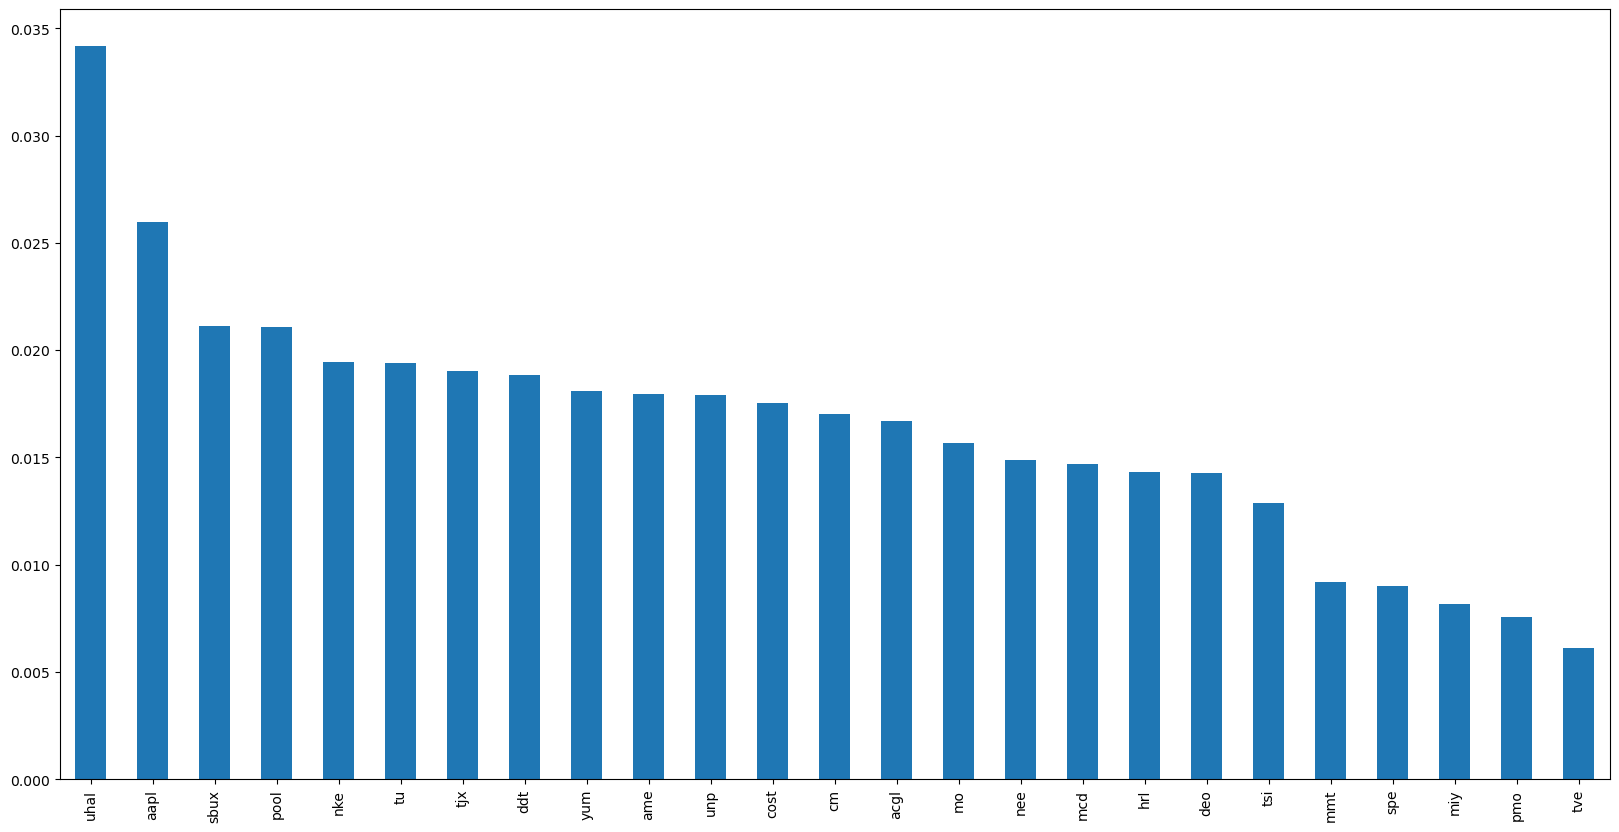

In [65]:
# Plot historical daily volatility
stocks_volatility['volatility'].sort_values(ascending=False).plot(kind='bar', figsize=(20, 10))

In [77]:
most_volatile_stock = stocks_volatility['volatility'].sort_values(ascending=False).index[0]
least_volatile_stock = stocks_volatility['volatility'].sort_values(ascending=False).index[-1]
window = 14

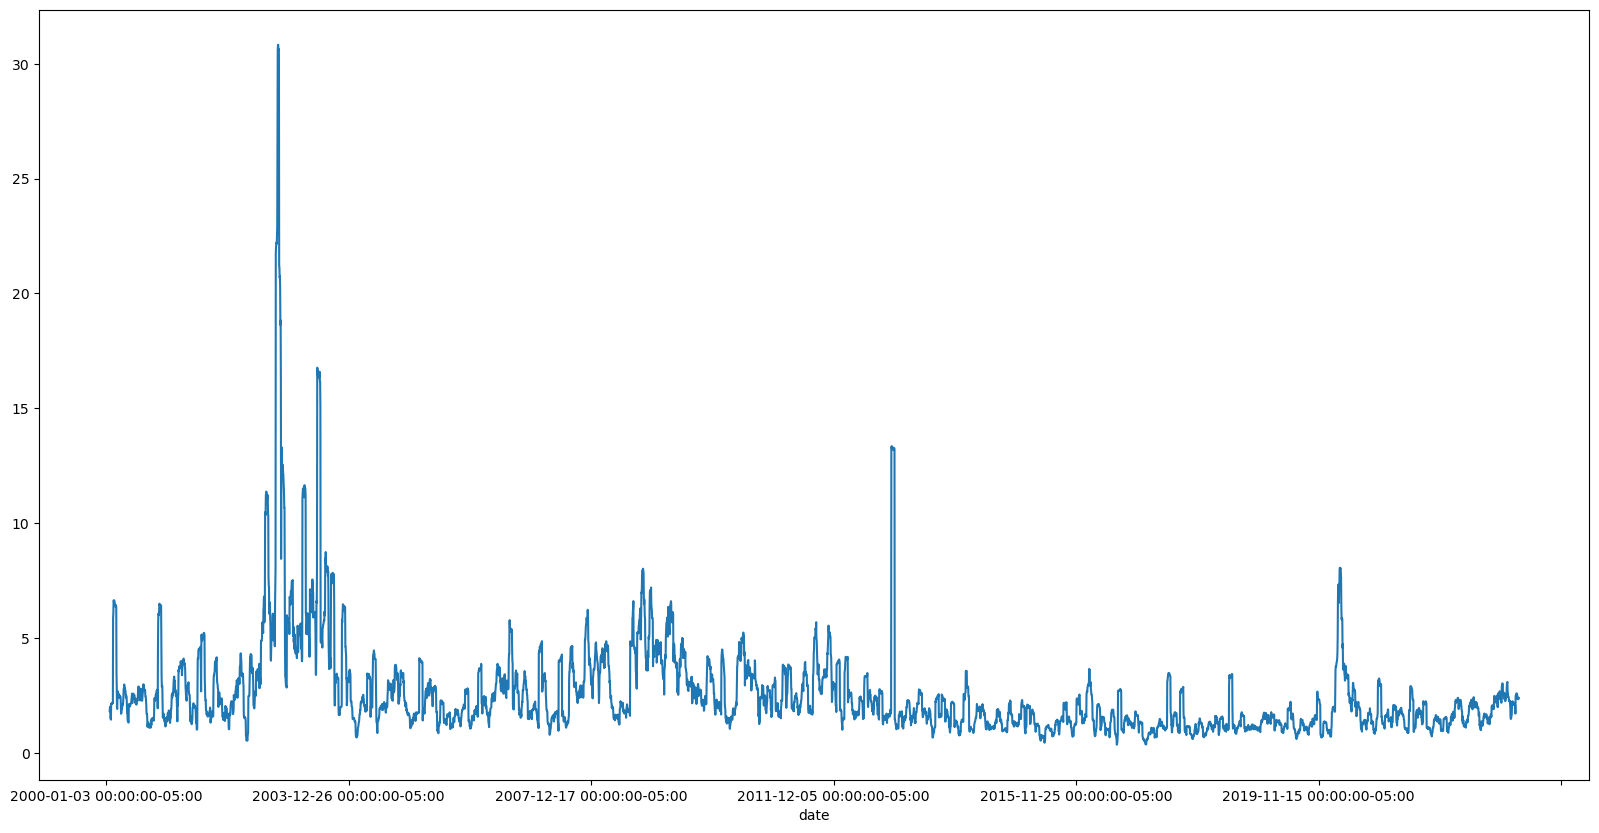

In [78]:
(stock_returns[most_volatile_stock].rolling(window).std() * 100).plot(figsize=(20, 10))

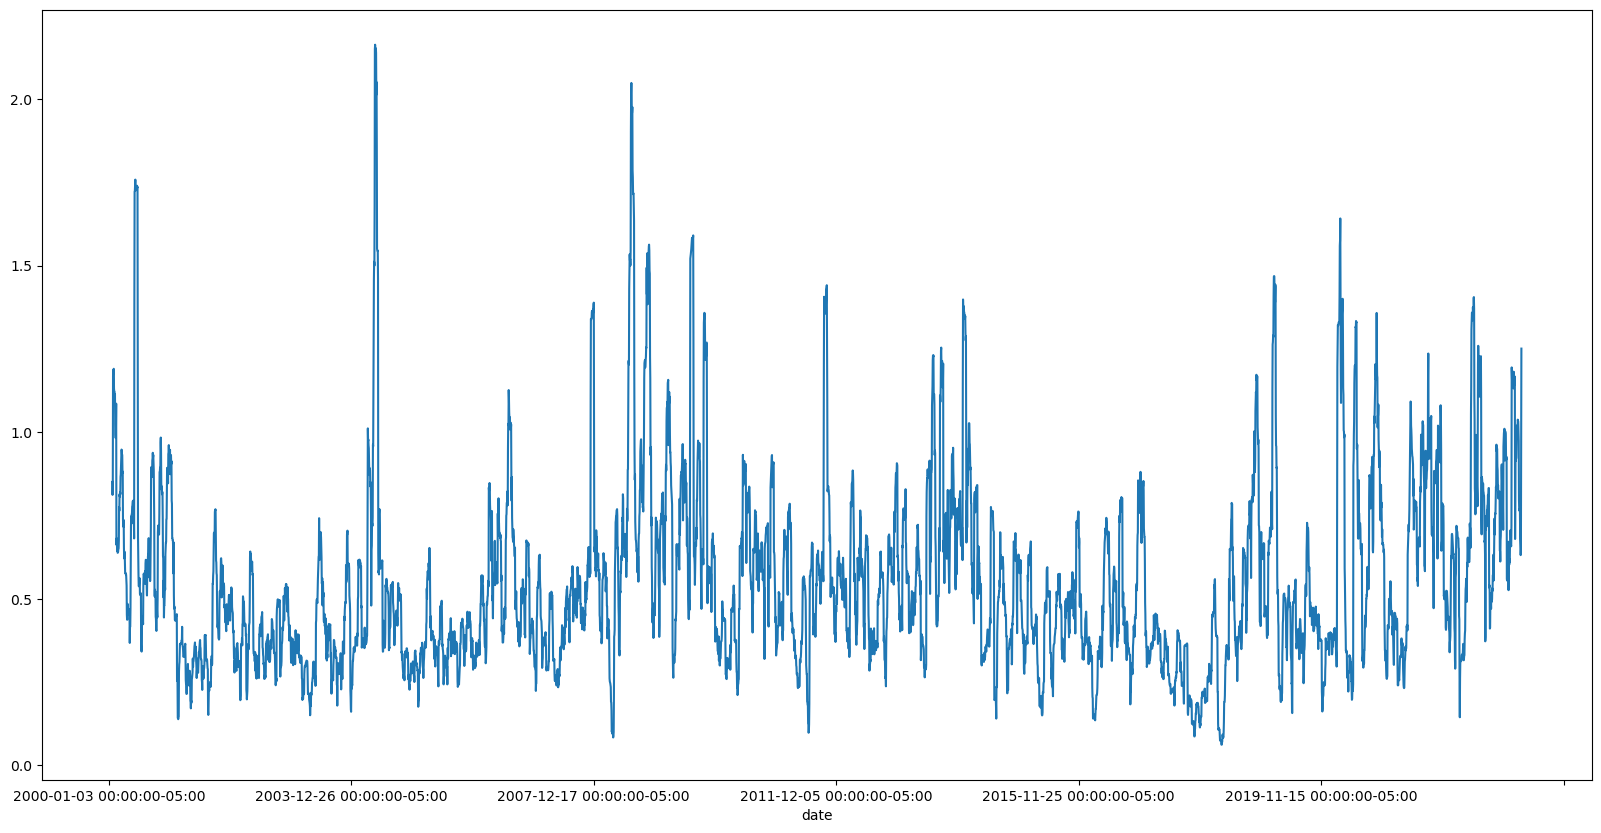

In [79]:
(stock_returns[least_volatile_stock].rolling(window).std() * 100).plot(figsize=(20, 10))